In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score,
    average_precision_score, confusion_matrix, precision_score,
    recall_score, f1_score, accuracy_score, classification_report,
    log_loss, brier_score_loss, precision_recall_fscore_support
)
from sklearn.calibration import calibration_curve
import seaborn as sns
from PIL import Image
from scipy import stats
import pandas as pd
from tqdm import tqdm
from typing import Dict, Tuple, List, Optional, Union, Any
from sklearn.calibration import calibration_curve
import seaborn as sns
from tabulate import tabulate
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Örnek veriler
data = {
    'Models': [ "MedrixNet" , "MedrixNet_AL" , "DenseNet_201" , "EfficientNet_B7", "ResNet_152", "Vision Transformer-B32"],
    'Accuracy':   [ 0.89 , 0.88 , 0.78 , 0.73 , 0.78 , 0.78 , 0.74 , 0.74],
    'Precision':  [ 0.94 , 0.94 , 0.84 , 0.78 , 0.83 , 0.81 , 0.78 , 0.78],
    'Recall':     [ 0.86 , 0.83 , 0.76 , 0.72 , 0.77 , 0.80 , 0.74 , 0.76],
    'F1-Score':   [ 0.90 , 0.88 , 0.80 , 0.75 , 0.80 , 0.80 , 0.76 , 0.77]
}

df = pd.DataFrame(data)
table_str = tabulate(df, headers='keys', tablefmt='fancy_grid')
print(table_str)

╒════╤═════════════════╤════════════╤═════════════╤══════════╤════════════╕
│    │ Models          │   Accuracy │   Precision │   Recall │   F1-Score │
╞════╪═════════════════╪════════════╪═════════════╪══════════╪════════════╡
│  0 │ MedrixNet       │       0.89 │        0.94 │     0.86 │       0.9  │
├────┼─────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  1 │ MedrixNet_AL    │       0.88 │        0.94 │     0.83 │       0.88 │
├────┼─────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  2 │ DenseNet_201    │       0.78 │        0.84 │     0.76 │       0.8  │
├────┼─────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  3 │ EfficientNet_B4 │       0.73 │        0.78 │     0.72 │       0.75 │
├────┼─────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  4 │ EfficientNet_B6 │       0.78 │        0.83 │     0.77 │       0.8  │
├────┼─────────────────┼────────────┼─────────────┼──────────┼────────────┤
│  5 │ ResNe

In [3]:
#@title Data Generator
def data_generator(path, target_size=(256, 256), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [4]:
#@title MedrixNet
def medrix_net(printtoggle=False):

    class theNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            self.print = printtoggle

            ###--------------- Feature Map Layers ---------------###

            # First Convolutional Layer
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            # output size: (np.floor((256 - 3 + 2*1) / 1) + 1)/2 = 128

            # Second Convolutional Layer
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(32)
            # output size: (np.floor((128 - 3 + 2*1) / 1) + 1)/2 = 64

            # Third Convolutional Layer
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.bnorm3 = nn.BatchNorm2d(64)
            # output size: (np.floor((64 - 3 + 2*1) / 1) + 1)/2 = 32

            # Fourth Convolutional Layer
            self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
            self.bnorm4 = nn.BatchNorm2d(128)
            # output size: (np.floor((32 - 3 + 2*1) / 1) + 1)/2 = 16

            # Fifth Convolutional Layer
            self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
            self.bnorm5 = nn.BatchNorm2d(256)
            # output size: (np.floor((16 - 3 + 2*1) / 1) + 1)/2 = 8

            # Sixth Convolutional Layer
            self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
            self.bnorm6 = nn.BatchNorm2d(512)
            # output size: (np.floor((8 - 3 + 2*1) / 1) + 1)/2 = 4

            # Seventh Convolutional Layer
            self.conv7 = nn.Conv2d(512, 1024, 3, padding=1)
            self.bnorm7 = nn.BatchNorm2d(1024)
            # output size: (np.floor((4 - 3 + 2*1) / 1) + 1)/2 = 2

            ###-------------- Linear Desicion Layers --------------###

            self.fc1 = nn.Linear(1024*2*2, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 32)
            self.fc4 = nn.Linear(32, 1)


        def forward(self, x):

            if self.print: print(f"Input shape: {x.shape}")

            # First Convolutional Layer
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            if self.print: print(f"After conv1: {x.shape}")

            # Second Convolutional Layer
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            if self.print: print(f"After conv2: {x.shape}")

            # Third Convolutional Layer
            x = F.max_pool2d(self.conv3(x),2)
            x = F.relu(self.bnorm3(x))
            if self.print: print(f"After conv3: {x.shape}")

            # Fourth Convolutional Layer
            x = F.max_pool2d(self.conv4(x),2)
            x = F.relu(self.bnorm4(x))
            if self.print: print(f"After conv4: {x.shape}")

            # Fifth Convolutional Layer
            x = F.max_pool2d(self.conv5(x),2)
            x = F.relu(self.bnorm5(x))
            if self.print: print(f"After conv5: {x.shape}")

            # Sixth Convolutional Layer
            x = F.max_pool2d(self.conv6(x),2)
            x = F.relu(self.bnorm6(x))
            if self.print: print(f"After conv6: {x.shape}")

            # Seventh Convolutional Layer
            x = F.max_pool2d(self.conv7(x),2)
            x = F.relu(self.bnorm7(x))
            if self.print: print(f"After conv7: {x.shape}")

            # Flatten the output
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f"After flatten: {x.shape}")

            # Linear Decision Layers
            x = F.relu(self.fc1(x))

            x = F.relu(self.fc2(x))

            x = F.relu(self.fc3(x))

            x = self.fc4(x)

            if self.print: print(f"Output shape: {x.shape}")

            return x

    net = theNet(printtoggle)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.0003, weight_decay=0.001)

    lossfunc = nn.BCEWithLogitsLoss()



    return net, optimizer, lossfunc

In [5]:
#@title MedrixNet-AL
def medrix_net_AL(printtoggle=False):

    # Channel Attention Modülü
    class ChannelAttention(nn.Module):
        def __init__(self, channels, reduction=16):
            super(ChannelAttention, self).__init__()
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
            self.max_pool = nn.AdaptiveMaxPool2d(1)

            self.fc = nn.Sequential(
                nn.Conv2d(channels, channels // reduction, 1),
                nn.ReLU(),
                nn.Conv2d(channels // reduction, channels, 1)
            )
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            avg_out = self.fc(self.avg_pool(x))
            max_out = self.fc(self.max_pool(x))
            out = avg_out + max_out
            return self.sigmoid(out)

    # Spatial Attention Modülü
    class SpatialAttention(nn.Module):
        def __init__(self, kernel_size=7):
            super(SpatialAttention, self).__init__()
            self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            # Kanal boyunca maksimum ve ortalama değerleri hesapla
            max_pool = torch.max(x, dim=1, keepdim=True)[0]
            avg_pool = torch.mean(x, dim=1, keepdim=True)

            # İki özellik haritasını birleştir
            concat = torch.cat([max_pool, avg_pool], dim=1)

            # Konvolüsyon ve sigmoid ile attention map oluştur
            attention_map = self.sigmoid(self.conv(concat))

            return attention_map

    # CBAM (Convolutional Block Attention Module)
    class CBAM(nn.Module):
        def __init__(self, channels, reduction=16, kernel_size=7):
            super(CBAM, self).__init__()
            self.channel_attention = ChannelAttention(channels, reduction)
            self.spatial_attention = SpatialAttention(kernel_size)

        def forward(self, x):
            # Channel attention uygula
            channel_att = self.channel_attention(x)
            x = x * channel_att

            # Spatial attention uygula
            spatial_att = self.spatial_attention(x)
            x = x * spatial_att

            return x, spatial_att

    # Ana Model Sınıfı
    class theNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            self.print = printtoggle

            ###--------------- Feature Map Layers ---------------###

            # First Convolutional Layer
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            # output size: (np.floor((256 - 3 + 2*1) / 1) + 1)/2 = 128

            # Second Convolutional Layer
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(32)
            # output size: (np.floor((128 - 3 + 2*1) / 1) + 1)/2 = 64

            # Third Convolutional Layer
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.bnorm3 = nn.BatchNorm2d(64)
            # output size: (np.floor((64 - 3 + 2*1) / 1) + 1)/2 = 32
            # Attention modülü ekle
            self.cbam3 = CBAM(64)

            # Fourth Convolutional Layer
            self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
            self.bnorm4 = nn.BatchNorm2d(128)
            # output size: (np.floor((32 - 3 + 2*1) / 1) + 1)/2 = 16

            # Fifth Convolutional Layer
            self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
            self.bnorm5 = nn.BatchNorm2d(256)
            # output size: (np.floor((16 - 3 + 2*1) / 1) + 1)/2 = 8
            # Attention modülü ekle
            self.cbam5 = CBAM(256)

            # Sixth Convolutional Layer
            self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
            self.bnorm6 = nn.BatchNorm2d(512)
            # output size: (np.floor((8 - 3 + 2*1) / 1) + 1)/2 = 4

            # Seventh Convolutional Layer
            self.conv7 = nn.Conv2d(512, 1024, 3, padding=1)
            self.bnorm7 = nn.BatchNorm2d(1024)
            # output size: (np.floor((4 - 3 + 2*1) / 1) + 1)/2 = 2
            # Attention modülü ekle
            self.cbam7 = CBAM(1024)

            ###-------------- Linear Desicion Layers --------------###

            self.fc1 = nn.Linear(1024*2*2, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 32)
            self.fc4 = nn.Linear(32, 1)

            # Attention map'leri saklamak için
            self.attention_maps = {}


        def forward(self, x):

            if self.print: print(f"Input shape: {x.shape}")

            # First Convolutional Layer
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            if self.print: print(f"After conv1: {x.shape}")

            # Second Convolutional Layer
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            if self.print: print(f"After conv2: {x.shape}")

            # Third Convolutional Layer
            x = F.max_pool2d(self.conv3(x),2)
            x = F.relu(self.bnorm3(x))
            # Attention uygula
            x, att_map3 = self.cbam3(x)
            # Attention map'i sakla
            self.attention_maps['cbam3'] = att_map3
            if self.print: print(f"After conv3 + attention: {x.shape}")

            # Fourth Convolutional Layer
            x = F.max_pool2d(self.conv4(x),2)
            x = F.relu(self.bnorm4(x))
            if self.print: print(f"After conv4: {x.shape}")

            # Fifth Convolutional Layer
            x = F.max_pool2d(self.conv5(x),2)
            x = F.relu(self.bnorm5(x))
            # Attention uygula
            x, att_map5 = self.cbam5(x)
            # Attention map'i sakla
            self.attention_maps['cbam5'] = att_map5
            if self.print: print(f"After conv5 + attention: {x.shape}")

            # Sixth Convolutional Layer
            x = F.max_pool2d(self.conv6(x),2)
            x = F.relu(self.bnorm6(x))
            if self.print: print(f"After conv6: {x.shape}")

            # Seventh Convolutional Layer
            x = F.max_pool2d(self.conv7(x),2)
            x = F.relu(self.bnorm7(x))
            # Attention uygula
            x, att_map7 = self.cbam7(x)
            # Attention map'i sakla
            self.attention_maps['cbam7'] = att_map7
            if self.print: print(f"After conv7 + attention: {x.shape}")

            # Flatten the output
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f"After flatten: {x.shape}")

            # Linear Decision Layers
            x = F.relu(self.fc1(x))

            x = F.relu(self.fc2(x))

            x = F.relu(self.fc3(x))

            x = self.fc4(x)

            if self.print: print(f"Output shape: {x.shape}")

            return x

        # Attention map'leri almak için yardımcı fonksiyon
        def get_attention_maps(self):
            return self.attention_maps

    # Modeli oluştur
    net = theNet(printtoggle)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.0003, weight_decay=0.001)

    lossfunc = nn.BCEWithLogitsLoss()

    return net, optimizer, lossfunc

In [6]:
# Test images

folder_path_NS = "/content/drive/My Drive/veriler/test/inmesiz"
folder_path_S = "/content/drive/My Drive/veriler/test/inmeli"

print("Images are loading...")
NS_test_images = data_generator(folder_path_NS)
S_test_images = data_generator(folder_path_S)

print(f"Total no stroke test images: {NS_test_images.shape[0]}")
print(f"No stroke test images shape: {NS_test_images[0].shape}")

print(f"Total stroke test images: {S_test_images.shape[0]}")
print(f"Stroke test images shape: {S_test_images[0].shape}")

Images are loading...
Total no stroke test images: 130
No stroke test images shape: torch.Size([3, 256, 256])
Total stroke test images: 167
Stroke test images shape: torch.Size([3, 256, 256])


In [8]:
# External test images

folder_path_external_NS = "/content/drive/My Drive/veriler/test/baska_test/inmesiz"
folder_path_external_S = "/content/drive/My Drive/veriler/test/baska_test/b_stroke"

print("Images are loading...")
external_NS_images = data_generator(folder_path_external_NS)
external_NS_images = external_NS_images[:192]
external_S_images = data_generator(folder_path_external_S)

print(f"Total external test no stroke images: {external_NS_images.shape[0]}")
print(f"External test no stroke images shape: {external_NS_images[0].shape}")

print(f"Total external test stroke images: {external_S_images.shape[0]}")
print(f"External test stroke images shape: {external_S_images[0].shape}")

Images are loading...
Total external test no stroke images: 192
External test no stroke images shape: torch.Size([3, 256, 256])
Total external test stroke images: 192
External test stroke images shape: torch.Size([3, 256, 256])


In [9]:
test_data = torch.cat((NS_test_images, S_test_images), dim=0)
test_labels = torch.cat((torch.zeros(NS_test_images.shape[0]), torch.ones(S_test_images.shape[0])), dim=0)
test_labels = test_labels[:,None]

external_data = torch.cat((external_NS_images, external_S_images), dim=0)
external_labels = torch.cat(
    (
        torch.zeros(external_NS_images.shape[0]),
        torch.ones(external_S_images.shape[0])
    ),
    dim=0
)
external_labels = external_labels[:,None]

In [11]:
batch_size = 32
test_dataset = TensorDataset(test_data, test_labels)
external_dataset = TensorDataset(external_data, external_labels)

test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
external_loader = DataLoader(external_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [26]:
#@title Binary Confidence Analysis
class BinaryConfidenceAnalysis:
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def get_predictions(self):
        """Get predictions and probabilities from test data"""
        y_true = []
        y_pred = []
        y_probs = []  # Probability of positive class (class 1)

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                # Handle different model output formats
                if outputs.shape[1] == 1:  # Single output (sigmoid)
                    probs = torch.sigmoid(outputs).squeeze()
                    preds = (probs >= 0.5).long()
                else:  # Two outputs (softmax)
                    probs = torch.softmax(outputs, dim=1)[:, 1]
                    preds = (probs >= 0.5).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        return np.array(y_true), np.array(y_pred), np.array(y_probs)

    def bootstrap_metrics(self, n_iterations=1000, ci=95):
        """Calculate metrics with confidence intervals using bootstrap"""
        y_true, y_pred, _ = self.get_predictions()

        # Arrays to store bootstrap results
        precisions = np.zeros(n_iterations)
        recalls = np.zeros(n_iterations)
        f1_scores = np.zeros(n_iterations)

        n_samples = len(y_true)

        # Bootstrap loop
        for i in range(n_iterations):
            # Sample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)

            # Calculate metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true[indices], y_pred[indices],
                average='binary', zero_division=0
            )

            precisions[i] = precision
            recalls[i] = recall
            f1_scores[i] = f1

        # Calculate confidence intervals
        alpha = (100 - ci) / 100 / 2
        ci_lower = alpha
        ci_upper = 1 - alpha

        results = {
            'precision': {
                'mean': np.mean(precisions),
                'ci': np.quantile(precisions, [ci_lower, ci_upper])
            },
            'recall': {
                'mean': np.mean(recalls),
                'ci': np.quantile(recalls, [ci_lower, ci_upper])
            },
            'f1': {
                'mean': np.mean(f1_scores),
                'ci': np.quantile(f1_scores, [ci_lower, ci_upper])
            }
        }

        return results

    def plot_metrics_with_ci(self):
        """Plot metrics with confidence intervals"""
        results = self.bootstrap_metrics()

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Metrics to plot
        metrics = ['precision', 'recall', 'f1']
        x_pos = np.arange(len(metrics))

        # Extract values
        means = [results[m]['mean'] for m in metrics]
        errors = [
            [results[m]['mean'] - results[m]['ci'][0] for m in metrics],
            [results[m]['ci'][1] - results[m]['mean'] for m in metrics]
        ]

        # Create bar plot with error bars
        ax.bar(x_pos, means, yerr=errors, align='center', alpha=0.7, capsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1.1)
        ax.set_ylabel('Score')
        ax.set_title('Performans Metrikleri (%95 güven aralığı)')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + 0.05, f'{v:.2f}', ha='center')

        return fig

    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        y_true, y_pred, _ = self.get_predictions()

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Normalize the confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues',
                    xticklabels=['Normal', 'İnme'],
                    yticklabels=['Normal', 'İnme'])
        plt.ylabel('Gerçek Etiketler')
        plt.xlabel('Öngörülern Etiketler')
        plt.title('Confusion Matrix')

        return plt.gcf()

    def plot_probability_distribution(self):
        """Plot probability distribution by class"""
        y_true, _, y_probs = self.get_predictions()

        # Ensure arrays are 1D
        y_true = np.array(y_true).flatten()
        y_probs = np.array(y_probs).flatten()

        # Debug information
        print(f"Shape of y_true: {y_true.shape}")
        print(f"Shape of y_probs: {y_probs.shape}")
        print(f"Unique values in y_true: {np.unique(y_true)}")

        plt.figure(figsize=(10, 6))

        # Create mask arrays for indexing
        mask_class0 = (y_true == 0)
        mask_class1 = (y_true == 1)

        # Make sure we have samples from both classes
        if np.any(mask_class0) and np.any(mask_class1):
            # Separate probabilities by true class
            class0_probs = y_probs[mask_class0]
            class1_probs = y_probs[mask_class1]

            # Plot distributions
            sns.histplot(class0_probs, color='blue', alpha=0.5,
                         bins=20, label='Normal')
            sns.histplot(class1_probs, color='red', alpha=0.5,
                         bins=20, label='İnme')

            # Add decision threshold line
            plt.axvline(x=0.5, color='black', linestyle='--')

            plt.xlabel('İnme için olasılık dağılımı')
            plt.ylabel('Count')
            plt.title('İnme Sınıfına Göre Tahmin Olasılıklarının Dağılımı')
            plt.legend()
        else:
            # Handle case where only one class is present
            present_class = 'İnme' if np.any(mask_class1) else 'Normal'
            plt.text(0.5, 0.5, f"Only {present_class} present in dataset",
                     ha='center', va='center', fontsize=14)
            plt.title("Unable to Plot Distribution - Single Class")

        return plt.gcf()

    def plot_calibration_curve(self):
        """Plot calibration curve with confidence interval"""
        y_true, _, y_probs = self.get_predictions()

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)

        # Calculate standard error for binomial proportion
        n_bins = len(prob_true)
        bin_total = np.bincount(np.digitize(y_probs, np.linspace(0, 1, n_bins + 1)) - 1,
                              minlength=n_bins)

        # For confidence interval
        std_err = np.sqrt(prob_true * (1 - prob_true) / np.maximum(bin_total, 1))
        ci = 1.96 * std_err  # 95% confidence interval

        # Plot
        plt.figure(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Plot with confidence intervals
        plt.errorbar(prob_pred, prob_true, yerr=ci,
                    marker='o', markersize=6, linewidth=2,
                    label='Model Calibration')

        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve with 95% Confidence Interval')
        plt.legend(loc='lower right')
        plt.grid(True)

        return plt.gcf()

Shape of y_true: (297,)
Shape of y_probs: (297,)
Unique values in y_true: [0. 1.]


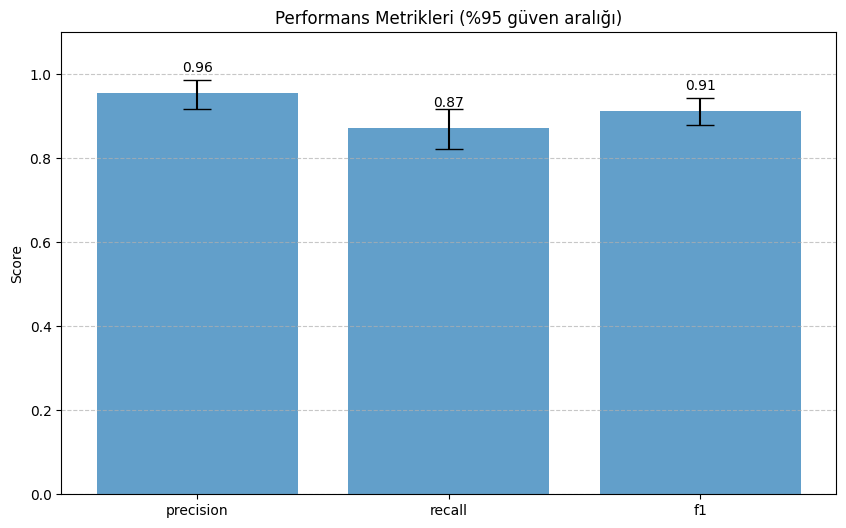

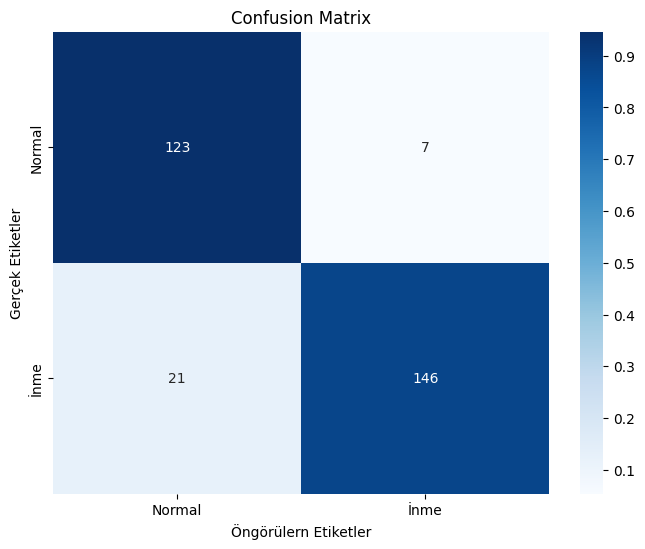

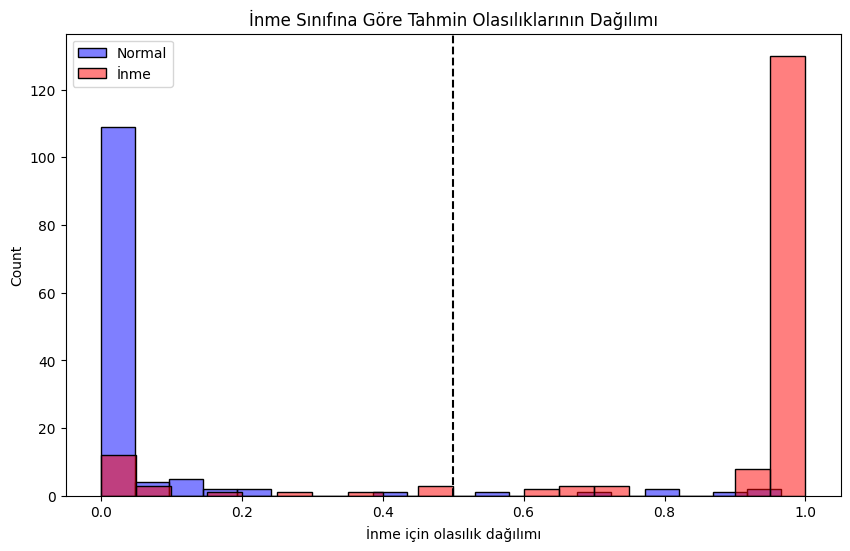

In [27]:
PATH = '/content/drive/MyDrive/model_weights/medrixnet.pth'

model = medrix_net(printtoggle=False)[0]
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()

analyzer = BinaryConfidenceAnalysis(model, test_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
# # Display all plots
plt.show()

Shape of y_true: (384,)
Shape of y_probs: (384,)
Unique values in y_true: [0. 1.]


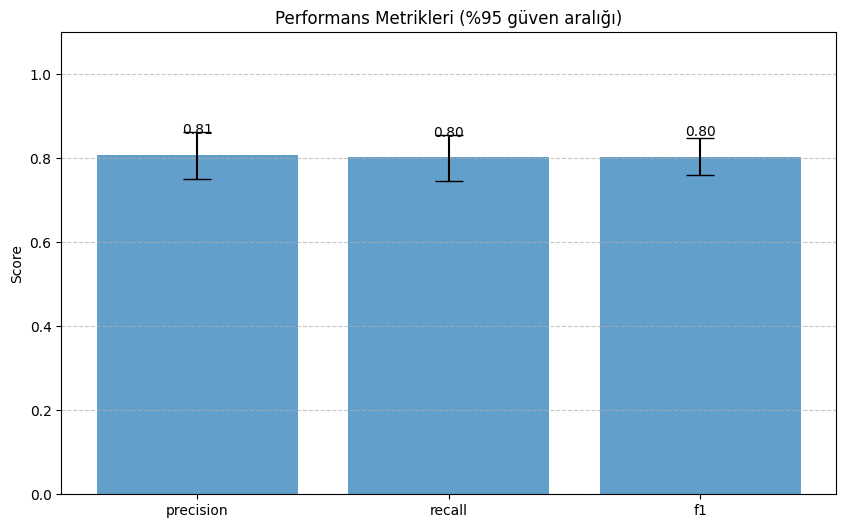

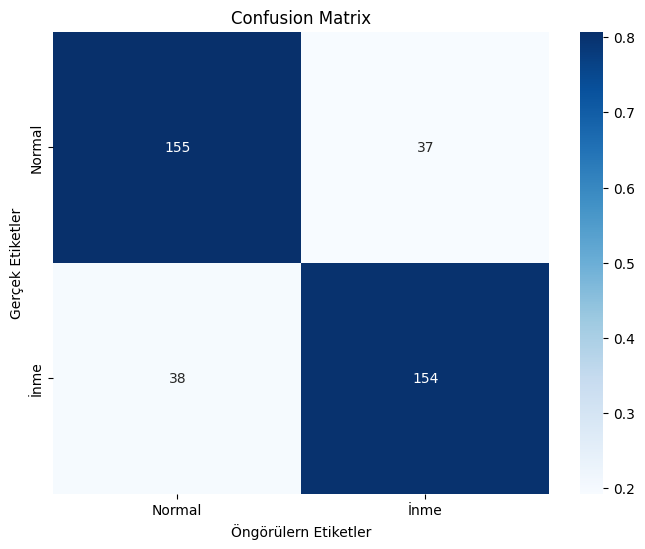

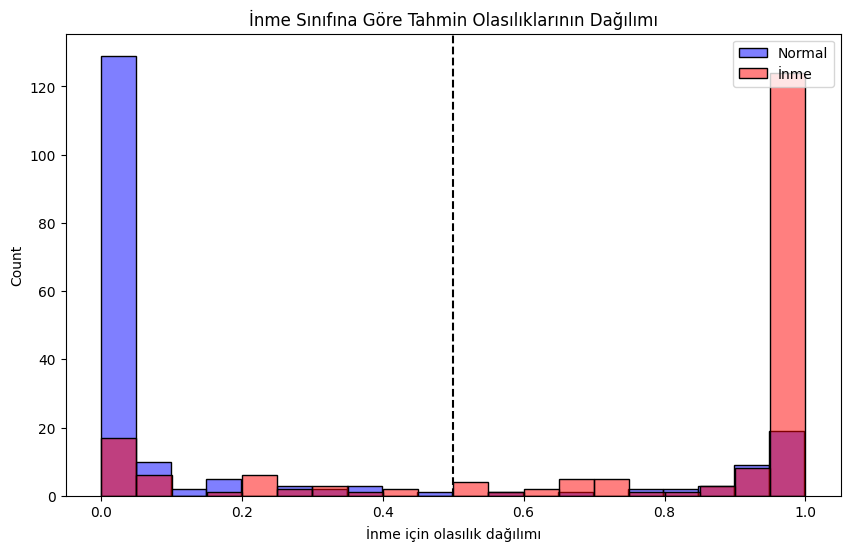

In [28]:
analyzer = BinaryConfidenceAnalysis(model, external_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
# # Display all plots
plt.show()

Shape of y_true: (297,)
Shape of y_probs: (297,)
Unique values in y_true: [0. 1.]


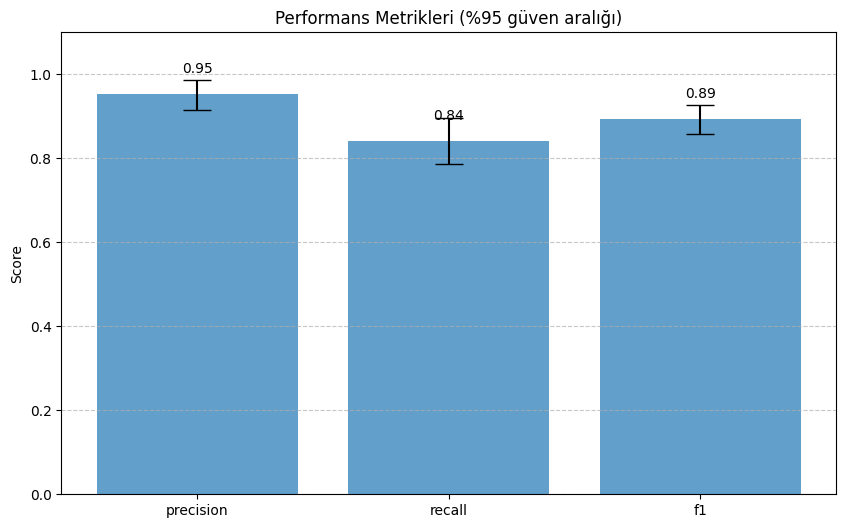

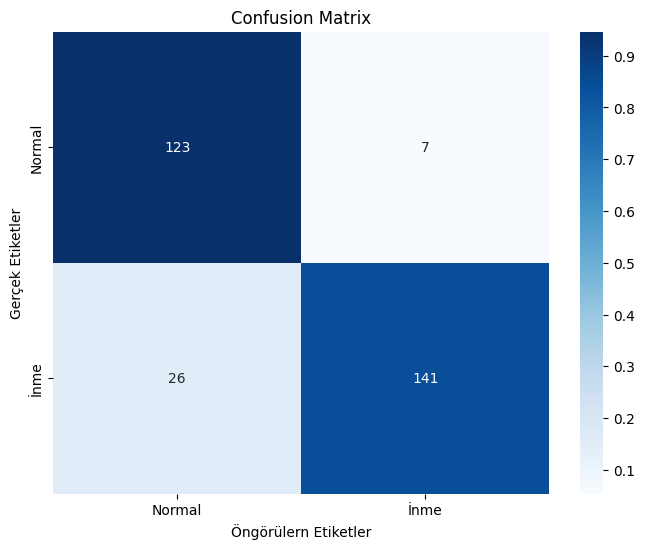

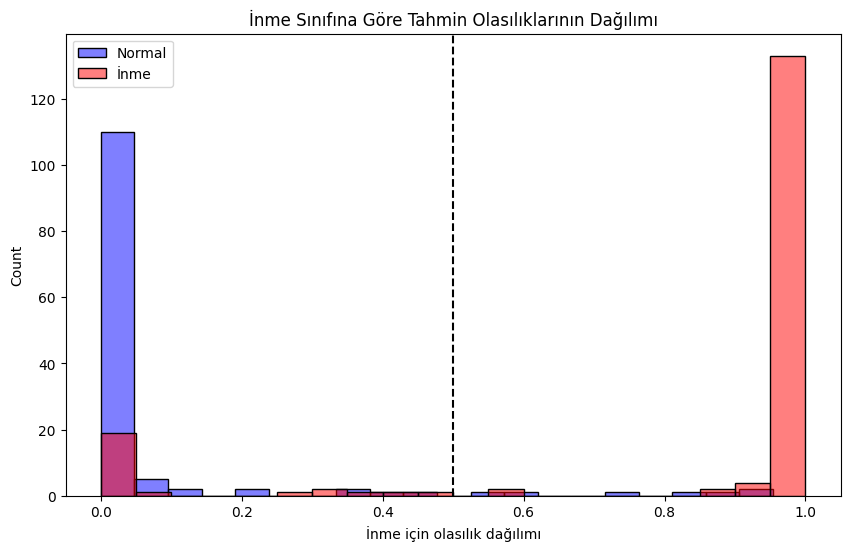

In [29]:
PATH = '/content/drive/MyDrive/model_weights/medrixnet_attention.pth'

model = medrix_net_AL(printtoggle=False)[0]
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()

analyzer = BinaryConfidenceAnalysis(model, test_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
# # Display all plots
plt.show()

Shape of y_true: (384,)
Shape of y_probs: (384,)
Unique values in y_true: [0. 1.]


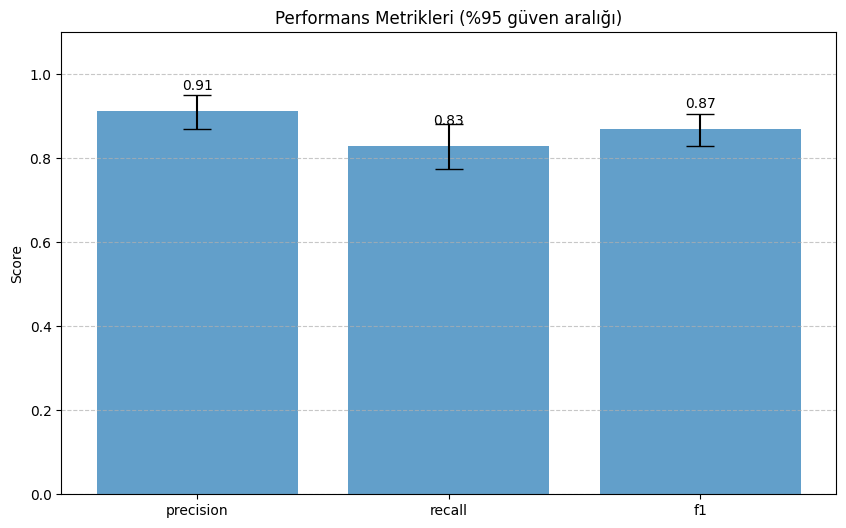

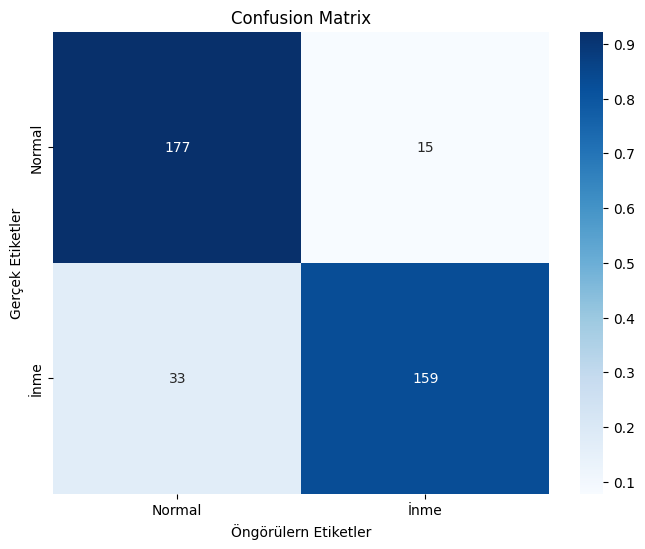

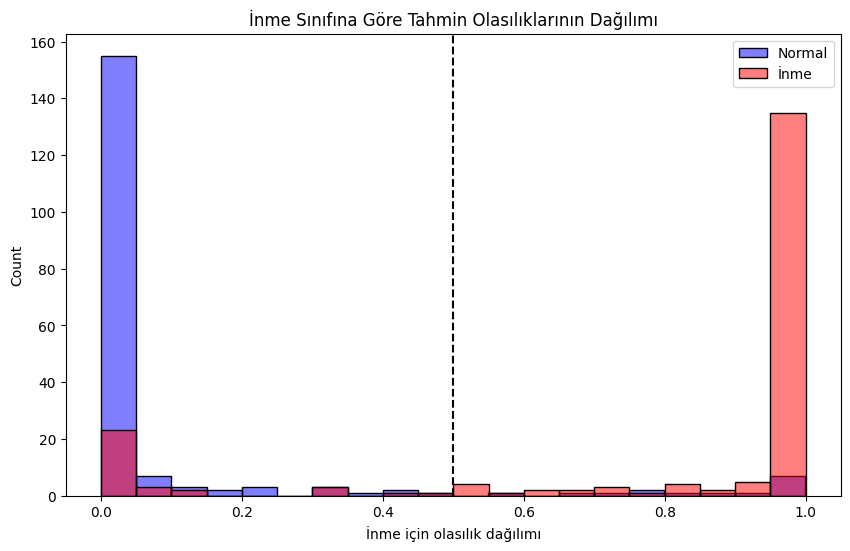

In [30]:
analyzer = BinaryConfidenceAnalysis(model, external_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
# # Display all plots
plt.show()